In [28]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Old Method

In [2]:
# Temporal hotspot
def is_win_thigh(win, ff):
    # "win" is of type numpy.ndarray
    c_ii = (len(win)-1)//2
    c = win[c_ii]
    m = np.maximum(win[:c_ii].max(), win[c_ii+1:].max())
    r = c >= (1 + ff)*m
    return r


def is_win_tlow(win, ff):
    # "win" is of type numpy.ndarray
    c_ii = (len(win)-1)//2
    c = win[c_ii]
    m = np.minimum(win[:c_ii].min(), win[c_ii+1:].min())
    r = c <= ff*m
    return r


In [3]:
def get_hotspots(data, sensor, params, locs):

    # get data and distances; data is expected to be a pandas.Series,
    # not pandas.DataFrame, containing only one column (either pm25 or
    # pm10)
    df = data.unstack(level=0)
    distances = pd.read_csv('/scratch/ab9738/epod-nyu-delhi-pollution/data/combined_distances.csv', index_col=[0])

    # select only the locations that are in the data
    distances = distances.loc[df.columns, df.columns]

    # invalidate diagonal entries so that sensor M does not get
    # counted in the M's radius
    distances[distances == 0] = np.nan

    # res: three digit entries 'abc' or NaN, where a/b/c = 1 or 9
    #
    # a == 9 => thigh, a == 1 => tlow
    # b == 9 => shigh, b == 1 => slow
    # c == 9 => jhigh, c == 1 => jlow
    res = pd.DataFrame(index=df.index, columns=df.columns)

    # (1) WINDOW HOTSPOTS

    # **Temporal Window Hotspot**: a timestamp is marked as a temporal
    # window hotspot if the value at that time is greater/lesser than
    # a window (radius "wtr") around it by a threshold fraction "wttf"
    wts = 2*params['wtr'] + 1
    rolling_wt = df.rolling(wts, min_periods=wts, center=True)
    res_win_thigh = rolling_wt.apply(is_win_thigh, raw=True, args=(params['wttf'],))
    res_win_tlow = rolling_wt.apply(is_win_tlow, raw=True, args=(params['wttf'],))
    res[res_win_thigh == 1] = 900
    res[res_win_tlow == 1] = 100

    # **Spatial Window Hotspot**: A location is marked as a
    # spatial window hotspot if, at a given time, the value at
    # that location is greater/lesser than the max of values in a
    # radius ("wsr") around it by a threshold frac "wstf"
    res_win_shigh = pd.DataFrame(index=df.index, columns=df.columns)
    res_win_slow = pd.DataFrame(index=df.index, columns=df.columns)
    for mid in df.columns:
        neighborhood = (distances.loc[mid] <= params['wsr'] * 1000)
        neighborhood_max = df.loc[:,neighborhood].max(axis=1)
        neighborhood_min = df.loc[:,neighborhood].min(axis=1)
        res_win_shigh.loc[:, mid] = (df[mid] > ((1 + params['wstf']) * neighborhood_max))
        res_win_shigh.loc[neighborhood_max.isna() | df[mid].isna(), mid] = np.nan
        res_win_slow.loc[:, mid]  = (df[mid] < (params['wstf'] * neighborhood_min))
        res_win_slow.loc[neighborhood_min.isna() | df[mid].isna(), mid] = np.nan
    res[(res_win_shigh == 1) & res.notna()] += 90
    res[(res_win_shigh == 1) & res.isna()] = 90
    res[(res_win_slow == 1) & res.notna()] += 10
    res[(res_win_slow == 1) & res.isna()] = 10

    # (2) JUMP HOTSPOTS

    # for jumps: first the data is smoothened using a rolling window
    # of radius "jtr", then every timestamp where the change from the
    # previous timestamp is greater/lesser than the threshold "jtv" is
    # marked, and finally a timestamp+location is marked as a hotspot
    # if the change in the values at that location is the
    # highest/lowest in a radius "jsr"
    rolling_j = df.rolling(2*params['jtr'] + 1, min_periods=1, center=True).mean().diff()
    res_jump_high = pd.DataFrame(index=df.index, columns=df.columns)
    res_jump_low = pd.DataFrame(index=df.index, columns=df.columns)
    for mid in df.columns:
        neighborhood = (distances.loc[mid] <= params['jsr'] * 1000)
        neighborhood_max = rolling_j.loc[:,neighborhood].max(axis=1)
        neighborhood_min = rolling_j.loc[:,neighborhood].min(axis=1)
        res_jump_high.loc[:, mid] = (rolling_j[mid] > params['jtv']).to_numpy() &\
        (rolling_j[mid] > neighborhood_max).to_numpy()
        res_jump_high.loc[rolling_j[mid].isna() | neighborhood_max.isna(), mid] = np.nan
        res_jump_low.loc[:, mid] = (rolling_j[mid] < -params['jtv']).to_numpy() &\
        (rolling_j[mid] < neighborhood_min).to_numpy()
        res_jump_low.loc[rolling_j[mid].isna() | neighborhood_min.isna(), mid] = np.nan
    res[(res_jump_high == 1) & res.notna()] += 9
    res[(res_jump_high == 1) & res.isna()] = 9
    res[(res_jump_low == 1) & res.notna()] += 1
    res[(res_jump_low == 1) & res.isna()] = 1
    
    return res

# Main

## Parameters of Data and Hotspots

In [4]:
source = 'combined'
sensor = 'pm25'
res_time = '3H'
res_space = '0'
wtr = 1
wttf = 0.5
wsr = 5.0
wstf = 0.5
jtr = 1
jsr = 5.0
jtv = 100 if sensor == 'pm25' else 200

## Data Loading

In [5]:
filepath_root = '/scratch/ab9738/epod-nyu-delhi-pollution/'
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

## Old Method Results

In [6]:
hotspots_params = {'wtr':wtr, 'wttf':wttf, 'wsr':wsr, 'wstf':wstf, 'jtr':jtr, 'jtv':jtv, 'jsr':jsr}
df_hotspot_old = get_hotspots(data, sensor, hotspots_params, locs)

In [7]:
(df_hotspot_old==900).sum().sum()

4293

## Testing Temporal Hotspot Distributions

In [76]:
df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/epod-nyu-delhi-pollution/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [77]:
diff_list = []
for col in list(df.columns):
    arr = df[col].dropna().to_numpy()
    diff_arr = np.zeros(len(arr)-1)
    for i in range(len(arr)-1):
        diff_arr[i] = abs(arr[i+1]-arr[i])
    diff_list.append(diff_arr)
    
diff = np.concatenate(diff_list)

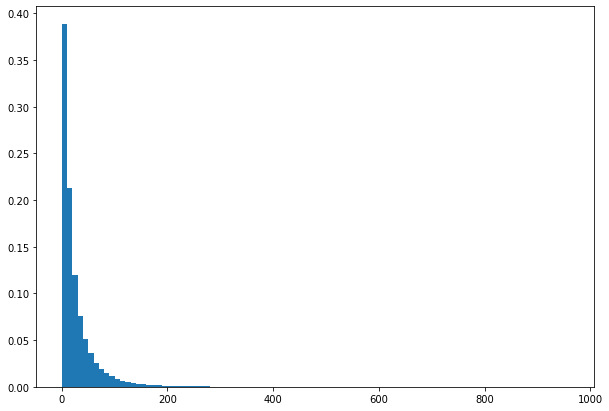

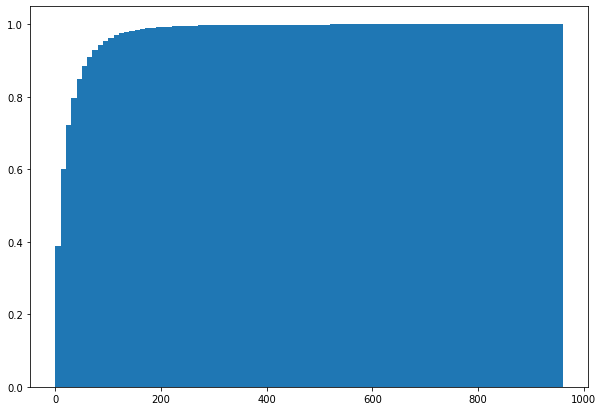

In [78]:
fig, ax = plt.subplots(figsize=(10,7))
stats = plt.hist(diff, weights=np.ones(len(diff))/len(diff), bins=range(int(min(diff)),int(max(diff)) + 10, 10),\
                 cumulative=False)
fig, ax = plt.subplots(figsize=(10,7))
_ = plt.hist(diff, weights=np.ones(len(diff))/len(diff), bins=range(int(min(diff)),int(max(diff)) + 10, 10),\
                 cumulative=True)

In [79]:
stats[0][:15].sum()

0.9827040920587299

In [80]:
(stats[0]*(stats[1]+5)[:-1]).sum()

27.654937456837644

In [81]:
mean = []
for col in list(df.columns):
    mean.append(df[col].dropna().mean())
sum(mean)/len(mean)

98.03664571878457

The value of 50 can be considered covering most of the contiguous jumps that happen. Beyond the point 100, jumps are considered rare (less than 5%). We can take 100 as the threshold for defining a hotspot.

## Write code for temporal hotspots

In [82]:
th = 150

In [130]:
def find_temporal_hotspots(arr, th):
    peak_indices = []
    hotspot_indices = []
    hotspot_windows = []
    plateau = 0
    for i in range(1,len(arr)-1):
        if(arr[i]>arr[i-1] and arr[i]>arr[i+1]):
            peak_indices.append(i)
    for ind in peak_indices:
        left_ind = ind-1
        right_ind = ind+1
        while(left_ind!=-1):
            if(arr[left_ind]<arr[left_ind+1]):
                left_ind -= 1
            else:
                break
        while(right_ind!=len(arr)):
            if(arr[right_ind]<arr[right_ind-1]):
                right_ind += 1
            else:
                break
        right_ind -= 1
        left_ind += 1
        if(left_ind==-1):
            left_ind = 0
        if(right_ind==len(arr)):
            right_ind = len(arr)-1
        val_left = arr[left_ind]
        val_right = arr[right_ind]
        val_peak = arr[ind]
        if(val_peak-val_right>th or val_peak-val_left>th):
            hotspot_indices.append(ind)
            hotspot_windows.append((left_ind,right_ind))
        if(abs(val_right-val_left)>th):
            plateau+=1
    return hotspot_indices, hotspot_windows, plateau

In [131]:
num_hsps, num_plts = 0,0
indices, windows = [], []
thsp = {}
for col in list(df.columns):
    thsp[col] = []
    arr = df[col].dropna().to_numpy()
    ts = df[col].dropna().index.to_numpy()
    hsp_ind, hsp_win, plat = find_temporal_hotspots(arr, th)
    for i in range(len(hsp_ind)):
        index = ts[hsp_ind[i]]
        value = df[col].dropna().loc[index]
        hsp_indices = ts[hsp_win[i][0]:hsp_win[i][1]+1]
        thsp[col].append([index, value, hsp_indices])
        
    indices += hsp_ind
    windows += hsp_win
    num_hsps += len(hsp_ind)
    num_plts += plat
print(num_hsps, num_plts)

9115 2284


## Analysis of Results

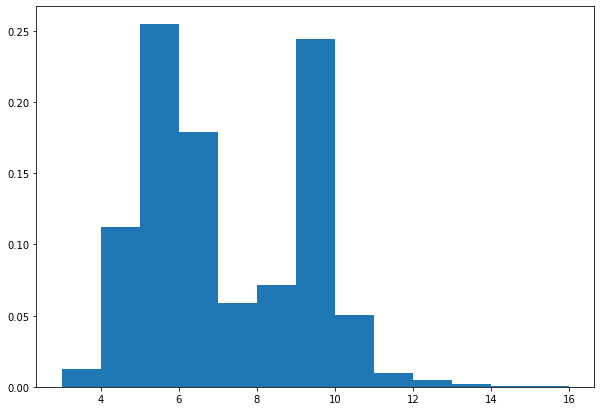

In [132]:
win_size = []
for win in windows:
    win_size.append(win[1]-win[0]+1)   

fig, ax = plt.subplots(figsize=(10,7))
stats = plt.hist(win_size, weights=np.ones(len(win_size))/len(win_size), \
                 bins=range(int(min(win_size)),int(max(win_size)) + 1, 1), cumulative=False)

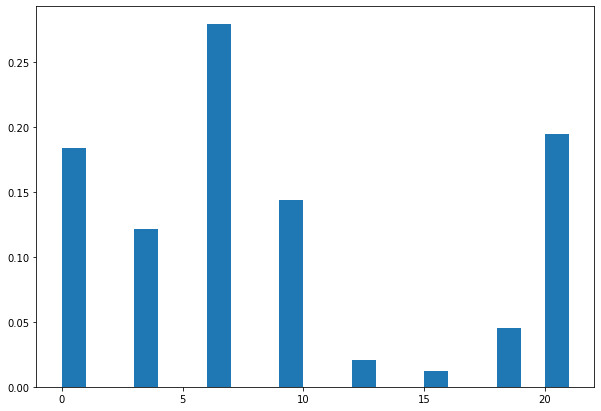

In [133]:
time_list = []
for col in df.columns:
    for entry in thsp[col]:
        time_list.append(entry[0].time().hour)
fig, ax = plt.subplots(figsize=(10,7))
stats = plt.hist(time_list, weights=np.ones(len(time_list))/len(time_list), \
                 bins=range(int(min(time_list)),int(max(time_list)) + 1, 1), cumulative=False)

In [134]:
abs_chk = 0
for col in df.columns:
    ohsp_index = df_hotspot_old[df_hotspot_old[col]==900].index
    for ind in ohsp_index:
        ts_after = ind + datetime.timedelta(hours=3)
        ts_before = ind - datetime.timedelta(hours=3)
        val = df[col].loc[ind]
        val_before = df[col].loc[ts_before]
        val_after = df[col].loc[ts_after]
        if(val - max(val_before, val_after) > th):
            abs_chk += 1
abs_chk

117

In [182]:
matching = {}
for col in df.columns:
    matching[col] = []
    ohsp_index = df_hotspot_old[df_hotspot_old[col]==900].index
    for ind in ohsp_index:
        for i in range(len(thsp[col])):
            if(ind > thsp[col][i][2][0] and ind < thsp[col][i][2][-1]):
                matching[col].append([thsp[col][i][0], ind])

In [183]:
num_match = 0
for col in df.columns:
    num_match += len(matching[col])
num_match

492

In [166]:
matching

{'113E': [[Timestamp('2019-03-01 06:00:00+0530', tz='pytz.FixedOffset(330)'),
   Timestamp('2019-03-01 06:00:00+0530', tz='pytz.FixedOffset(330)')],
  [Timestamp('2019-03-07 06:00:00+0530', tz='pytz.FixedOffset(330)'),
   Timestamp('2019-03-07 06:00:00+0530', tz='pytz.FixedOffset(330)')],
  [Timestamp('2019-03-15 06:00:00+0530', tz='pytz.FixedOffset(330)'),
   Timestamp('2019-03-15 06:00:00+0530', tz='pytz.FixedOffset(330)')],
  [Timestamp('2019-03-17 06:00:00+0530', tz='pytz.FixedOffset(330)'),
   Timestamp('2019-03-17 06:00:00+0530', tz='pytz.FixedOffset(330)')],
  [Timestamp('2019-03-18 06:00:00+0530', tz='pytz.FixedOffset(330)'),
   Timestamp('2019-03-18 06:00:00+0530', tz='pytz.FixedOffset(330)')]],
 '1FD7': [[Timestamp('2018-10-13 06:00:00+0530', tz='pytz.FixedOffset(330)'),
   Timestamp('2018-10-13 06:00:00+0530', tz='pytz.FixedOffset(330)')],
  [Timestamp('2019-03-15 06:00:00+0530', tz='pytz.FixedOffset(330)'),
   Timestamp('2019-03-15 06:00:00+0530', tz='pytz.FixedOffset(330)'

### Visualization for difference

In [168]:
arr = np.array(thsp['113E'])
viz_data = arr[arr[:,0]==matching['113E'][2][0]]
df['113E'].loc[viz_data[0][2]]

/state/partition1/job-18182219/ipykernel_3798856/2276815916.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(thsp['113E'])


timestamp_round
2019-03-14 15:00:00+05:30     24.800000
2019-03-14 18:00:00+05:30     41.138889
2019-03-14 21:00:00+05:30     73.250000
2019-03-15 00:00:00+05:30     90.583333
2019-03-15 03:00:00+05:30    114.444444
2019-03-15 06:00:00+05:30    235.555556
2019-03-15 09:00:00+05:30     93.655172
2019-03-15 12:00:00+05:30     40.729730
2019-03-15 15:00:00+05:30     28.500000
Name: 113E, dtype: float64

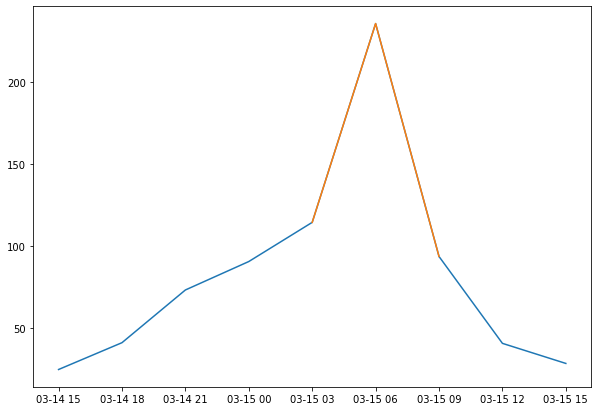

In [169]:
x = df['113E'].loc[viz_data[0][2]].index.to_numpy()
ts_before = matching['113E'][2][1] - datetime.timedelta(hours=3)
ts_after = matching['113E'][2][1] + datetime.timedelta(hours=3)
x_or = np.array([ts_before, matching['113E'][2][1], ts_after])
y_or = np.array([df['113E'].loc[ts_before], df['113E'].loc[matching['113E'][2][1]], df['113E'].loc[ts_after]])
y = df['113E'].loc[viz_data[0][2]].to_numpy()
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(x,y)
plt.plot(x_or,y_or)

## Testing Spatial Hotspot Distributions

In [8]:
df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/epod-nyu-delhi-pollution/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [9]:
nn_dict = {}
for col in df.columns:
    dist_df = distances.loc[col].sort_values().dropna()
    nn_dict[col] = dist_df

In [10]:
diff_list = []
for index in list(df.index):
    for col in df.columns:
        diff_val = abs(df.loc[index][col] - df.loc[index][nn_dict[col].index[0]])
        diff_list.append(diff_val)
diff = np.array(diff_list)
diff = diff[~np.isnan(diff)]

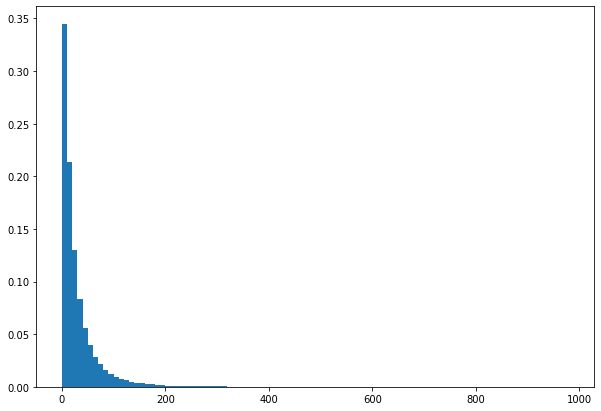

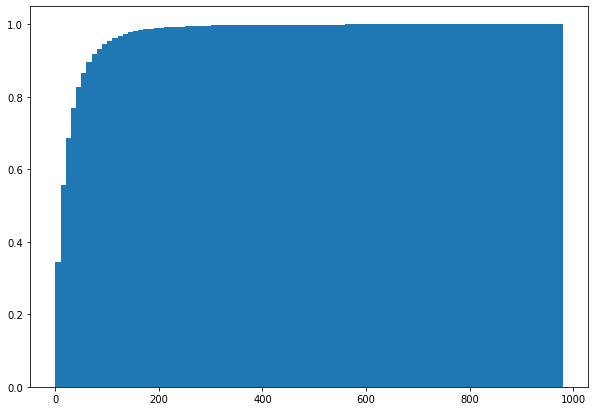

In [11]:
fig, ax = plt.subplots(figsize=(10,7))
stats = plt.hist(diff, weights=np.ones(len(diff))/len(diff), bins=range(int(min(diff)),int(max(diff)) + 10, 10),\
                 cumulative=False)
fig, ax = plt.subplots(figsize=(10,7))
_ = plt.hist(diff, weights=np.ones(len(diff))/len(diff), bins=range(int(min(diff)),int(max(diff)) + 10, 10),\
                 cumulative=True)

In [12]:
stats[0][:15].sum()

0.9776874466599105

In [13]:
(stats[0]*(stats[1]+5)[:-1]).sum()

30.81058748659437

## Writing code for spatial hotspots

In [39]:
th = 150
rad_th = 10

In [15]:
def area(x1, y1, x2, y2, x3, y3):
 
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1)
                + x3 * (y1 - y2)) / 2.0)

def isInside(x1, y1, x2, y2, x3, y3, x, y):
 
    # Calculate area of triangle ABC
    A = area (x1, y1, x2, y2, x3, y3)
 
    # Calculate area of triangle PBC
    A1 = area (x, y, x2, y2, x3, y3)
     
    # Calculate area of triangle PAC
    A2 = area (x1, y1, x, y, x3, y3)
     
    # Calculate area of triangle PAB
    A3 = area (x1, y1, x2, y2, x, y)
     
    # Check if sum of A1, A2 and A3
    # is same as A
    if(A == A1 + A2 + A3):
        return True
    else:
        return False

def find_interior_points(hsp, pt, nnk, rem_pts):
    hsp_cord = (locs.loc[hsp]['Latitude'],locs.loc[hsp]['Longitude'])
    pt_cord = (locs.loc[pt]['Latitude'],locs.loc[pt]['Longitude'])
    nnk_cord = (locs.loc[nnk]['Latitude'],locs.loc[nnk]['Longitude'])
    interior_pts = []
    for point in rem_pts:
        cord = (locs.loc[point]['Latitude'],locs.loc[point]['Longitude'])
        if(isInside(hsp_cord[0],hsp_cord[1],pt_cord[0],pt_cord[1],nnk_cord[0],nnk_cord[1],cord[0],cord[1])):
            interior_pts.append(point)
    return interior_pts

def check_interior_condition(hsp, hsp_set, nnk, snap):
    if(snap[hsp]-snap[nnk]<th):
        return False
    if(len(hsp_set)<=1):
        return True
    
    for pt in hsp_set:
        int_pts = find_interior_points(hsp, pt, nnk, [x for x in hsp_set if x != pt])
        for intpt in int_pts:
            if(snap[intpt]<snap[nnk] or snap[intpt]<snap[pt]):
                return False
    return True

In [40]:
hotspots = []
for ts in tqdm(list(df.index)):
    df_snap = df.loc[ts].dropna()
    loc_list = list(df_snap.index)
    for location in loc_list:
        available_locs = [x for x in loc_list if x != location]
        nn_locs = list(nn_dict[location][nn_dict[location]<rad_th*1000].index)
        nn_list = [x for x in nn_locs if x in available_locs]
#         if(df_snap[location]-df_snap[nn_list[0]]>th):
        hsp = location
#         hsp_set = [nn_list[0]]
        hsp_set = []
        for nnk in nn_list:
            if(check_interior_condition(hsp,hsp_set,nnk,df_snap)):
                hsp_set.append(nnk)
        if(len(hsp_set)):
            hotspots.append([ts,hsp,hsp_set])

100%|██████████| 7320/7320 [03:25<00:00, 35.56it/s] 


## Analysing results of new method

In [41]:
len(hotspots)

11329

In [42]:
hotspots

[[Timestamp('2018-05-01 12:00:00+0530', tz='pytz.FixedOffset(330)'),
  'MandirMarg_DPCC',
  ['MDCNS_DPCC',
   'ITO_CPCB',
   'Pusa_IMD',
   'Shadipur_CPCB',
   'AshokVihar_DPCC',
   'JNS_DPCC',
   'Wazirpur_DPCC',
   'PunjabiBagh_DPCC',
   'RKPuram_DPCC',
   'Patparganj_DPCC',
   'BC46',
   'NehruNagar_DPCC',
   'BB4A',
   'SoniaVihar_DPCC']],
 [Timestamp('2018-05-02 15:00:00+0530', tz='pytz.FixedOffset(330)'),
  'AyaNagar_IMD',
  ['5D7A', '91B8', 'C0A7']],
 [Timestamp('2018-05-02 15:00:00+0530', tz='pytz.FixedOffset(330)'),
  'BurariCrossing_IMD',
  ['Jahangirpuri_DPCC',
   'AshokVihar_DPCC',
   'Wazirpur_DPCC',
   'Rohini_DPCC',
   'PunjabiBagh_DPCC',
   'DTU_CPCB',
   'Shadipur_CPCB']],
 [Timestamp('2018-05-02 15:00:00+0530', tz='pytz.FixedOffset(330)'),
  'CRRIMathuraRoad_IMD',
  ['OkhlaPhase2_DPCC',
   'NehruNagar_DPCC',
   '498F',
   'JNS_DPCC',
   'DKSSR_DPCC',
   'E47A',
   'MDCNS_DPCC',
   'RKPuram_DPCC']],
 [Timestamp('2018-05-02 18:00:00+0530', tz='pytz.FixedOffset(330)'),
 

In [43]:
(df_hotspot_old==90).sum().sum()

8913

In [44]:
hotspots_arr = np.array(hotspots)

/state/partition1/job-18182219/ipykernel_3852878/1056094932.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hotspots_arr = np.array(hotspots)


In [45]:
matching = []
for idx in tqdm(df.index):
    hsps = list(df_hotspot_old.loc[idx][df_hotspot_old.loc[idx]==90].index)
    entry = hotspots_arr[hotspots_arr[:,0]==idx]
    if(entry.size):
        hsp = entry[0][1]
        hsp_set = entry[0][2]
#         import pdb; pdb.set_trace()
        for i in hsps:
            if (i==hsp or i in hsp_set):
                matching.append([idx, i, hsp, hsp_set])

100%|██████████| 7320/7320 [00:09<00:00, 755.88it/s]


In [46]:
len(matching)

476

In [47]:
matching

[[Timestamp('2018-05-01 12:00:00+0530', tz='pytz.FixedOffset(330)'),
  'Pusa_IMD',
  'MandirMarg_DPCC',
  ['MDCNS_DPCC',
   'ITO_CPCB',
   'Pusa_IMD',
   'Shadipur_CPCB',
   'AshokVihar_DPCC',
   'JNS_DPCC',
   'Wazirpur_DPCC',
   'PunjabiBagh_DPCC',
   'RKPuram_DPCC',
   'Patparganj_DPCC',
   'BC46',
   'NehruNagar_DPCC',
   'BB4A',
   'SoniaVihar_DPCC']],
 [Timestamp('2018-05-02 15:00:00+0530', tz='pytz.FixedOffset(330)'),
  'AyaNagar_IMD',
  'AyaNagar_IMD',
  ['5D7A', '91B8', 'C0A7']],
 [Timestamp('2018-05-03 09:00:00+0530', tz='pytz.FixedOffset(330)'),
  '91B8',
  'AyaNagar_IMD',
  ['5D7A', '91B8', 'C0A7']],
 [Timestamp('2018-05-04 15:00:00+0530', tz='pytz.FixedOffset(330)'),
  'AyaNagar_IMD',
  'AyaNagar_IMD',
  ['5D7A', 'C0A7']],
 [Timestamp('2018-05-05 12:00:00+0530', tz='pytz.FixedOffset(330)'),
  'BurariCrossing_IMD',
  'BurariCrossing_IMD',
  ['Shadipur_CPCB']],
 [Timestamp('2018-05-07 09:00:00+0530', tz='pytz.FixedOffset(330)'),
  'DTU_CPCB',
  'DTU_CPCB',
  ['Rohini_DPCC', 

In [48]:
matching[1]

[Timestamp('2018-05-02 15:00:00+0530', tz='pytz.FixedOffset(330)'),
 'AyaNagar_IMD',
 'AyaNagar_IMD',
 ['5D7A', '91B8', 'C0A7']]

In [49]:
df.loc[matching[1][0]].dropna()

field_egg_id
498F                    52.972222
5D7A                    56.323529
91B8                    63.416667
AnandVihar_DPCC         79.670000
AshokVihar_DPCC        111.670000
AyaNagar_IMD           529.050000
BB4A                    56.750000
BC46                    58.888889
BurariCrossing_IMD     279.100000
C0A7                    64.666667
CRRIMathuraRoad_IMD    225.980000
D804                    79.166667
DKSSR_DPCC              37.170000
DTU_CPCB               107.330000
DwarkaSector8_DPCC      50.670000
E47A                    62.777778
IGIAirport_IMD          66.210000
IHBAS_CPCB              96.050000
ITO_CPCB               100.830000
JNS_DPCC                40.380000
Jahangirpuri_DPCC       96.000000
LodhiRoad_IMD           86.610000
MDCNS_DPCC              44.330000
MandirMarg_DPCC         82.000000
NSIT_CPCB               98.090000
NehruNagar_DPCC         63.000000
OkhlaPhase2_DPCC        42.280000
Patparganj_DPCC         47.330000
PunjabiBagh_DPCC        96.330000
P

In [51]:
locs

,UDID,Latitude,Longitude,Address,Location,Type
Monitor ID,,,,,,
BB4A,492457f434f94afc865bb4701990bb4a,28.554980,77.194430,Jamun,Hauz Khas Village,Kaiterra
91B8,ea3ceeefd9654dfd9aab41422f7391b8,28.503050,77.185660,Vihara,Chhatapur,Kaiterra
BC46,29b8262425cf4135899cd65b2458bc46,28.632950,77.288700,Segel Design,Preet Vihar,Kaiterra
BFDC,11047d2ddc514f63a12ad4f1ad3bbfdc,28.521083,77.214237,Arundhati,Saket,Kaiterra
D804,f083e8afd43e4727a5eb7f3a1529d804,28.558230,77.208620,EPoD,Yusuf Sarai,Kaiterra
...,...,...,...,...,...,...
Sirifort_CPCB,NaN,28.550425,77.215938,NaN,"Sirifort, New Delhi - CPCB",Govt
SoniaVihar_DPCC,NaN,28.710508,77.249485,NaN,"Sonia Vihar, Delhi - DPCC",Govt
SriAurobindoMarg_DPCC,NaN,28.531346,77.190156,NaN,"Sri Aurobindo Marg, Delhi - DPCC",Govt


In [52]:
list_loc = list(set(matching[1][3]+[matching[1][2]]+[matching[1][1]]+\
    list(nn_dict[matching[1][1]][nn_dict[matching[1][1]]<wsr*1000].index)))
locs_map = locs.loc[list_loc]

(28.415079, 28.7500499)
(77.0325413, 77.372281)
28.588432487096775 77.20127194516128


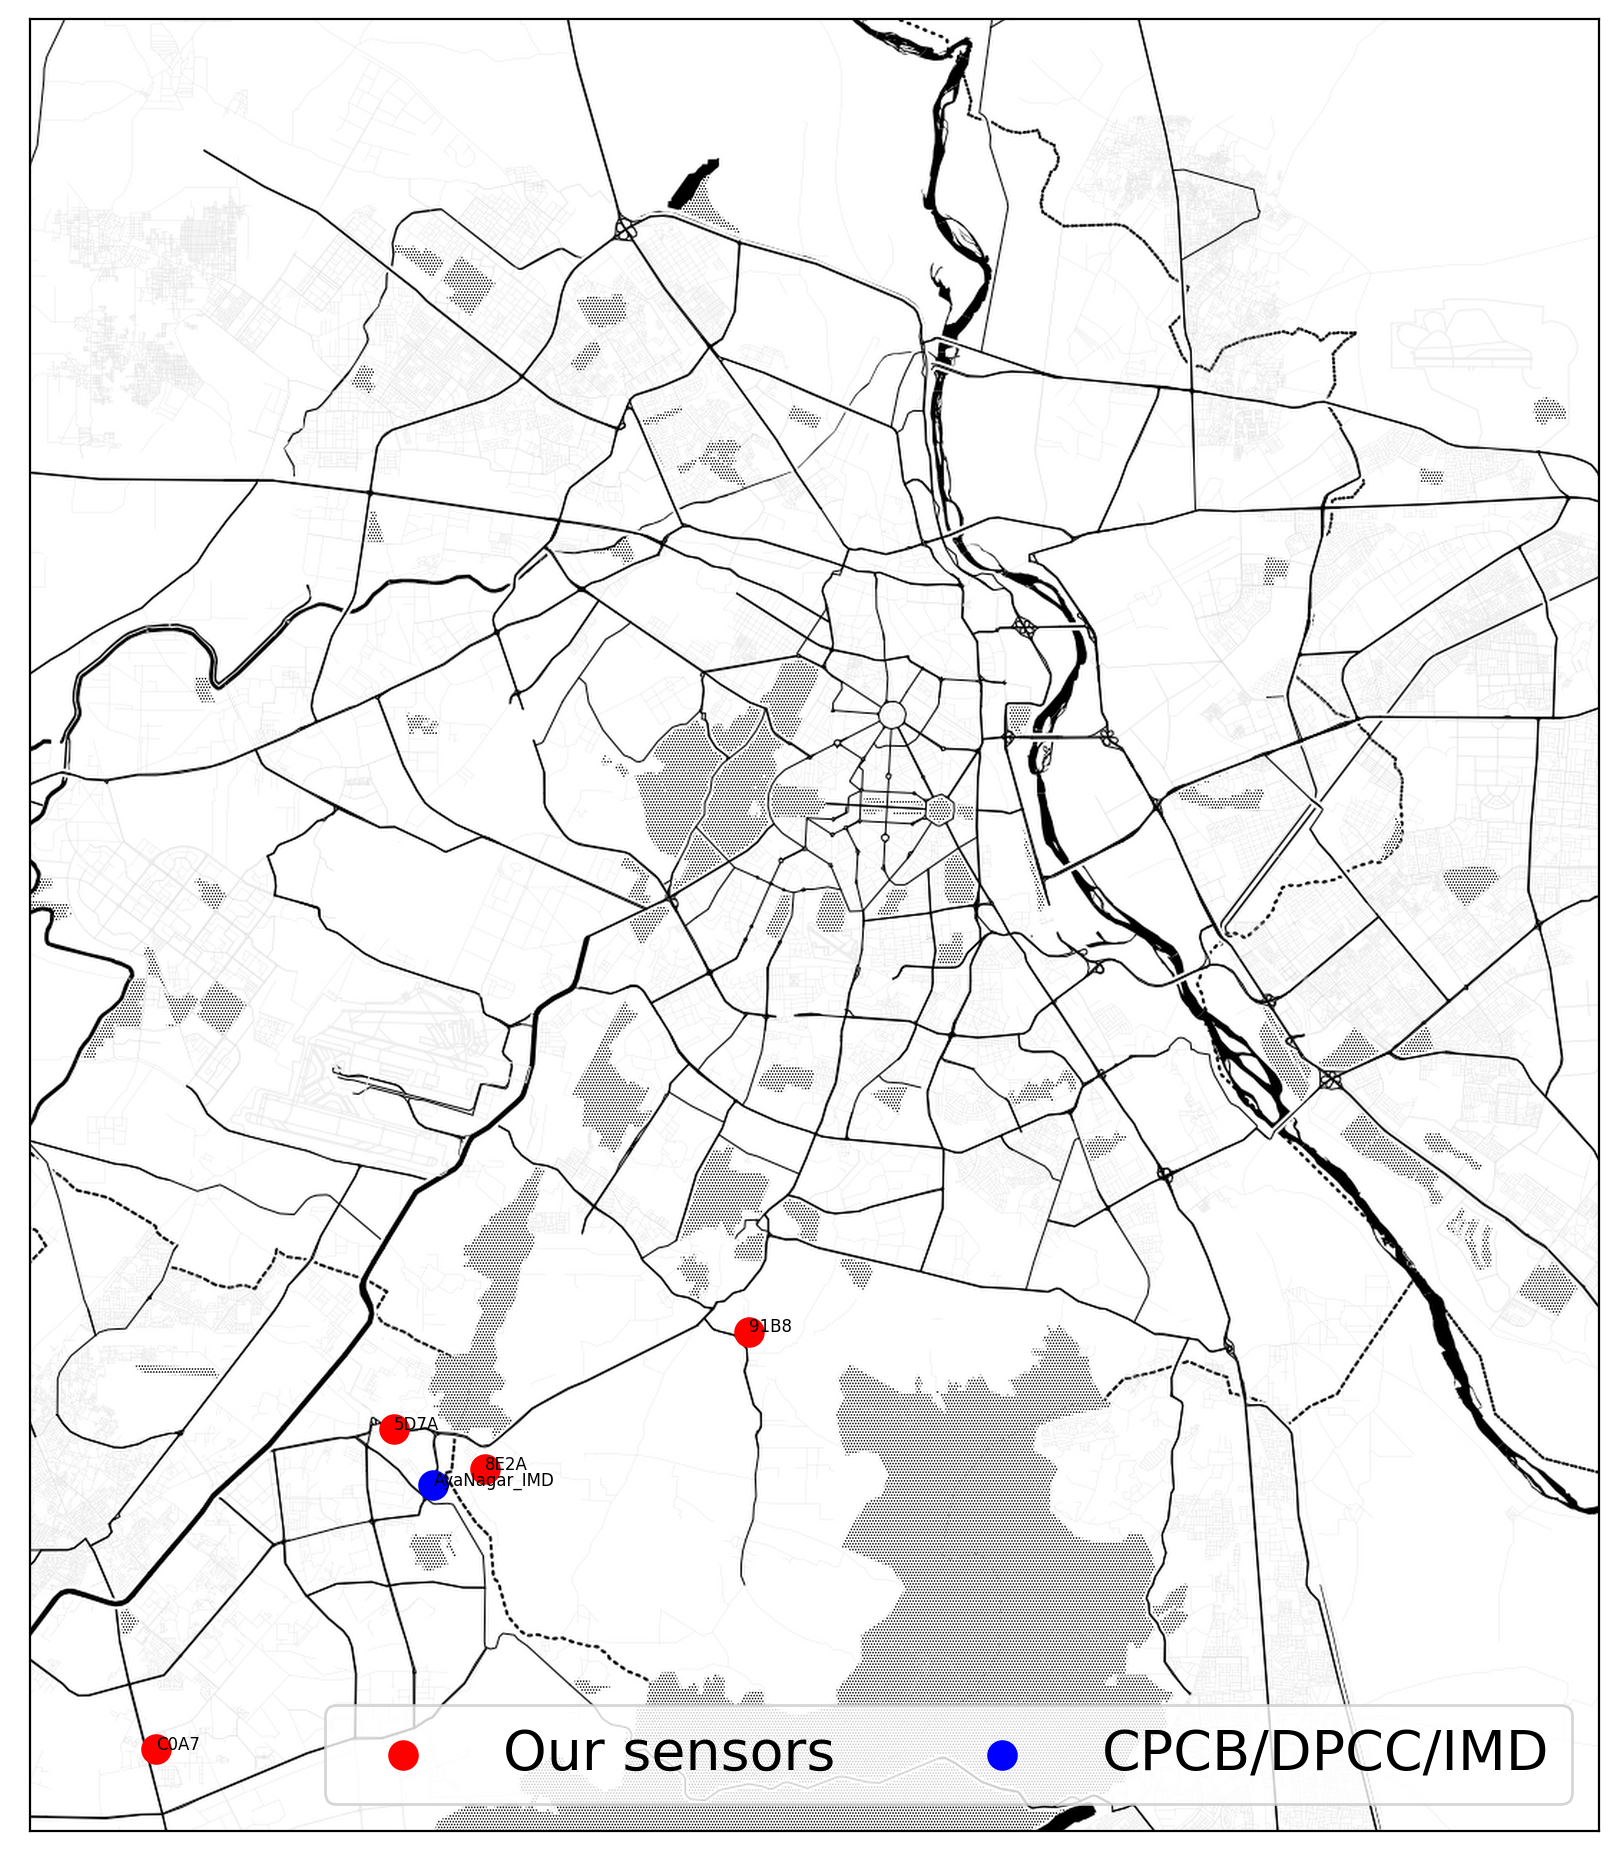

In [53]:
lat_lims = locs.Latitude.min(), locs.Latitude.max()
lon_lims = locs.Longitude.min(), locs.Longitude.max()
lon_center, lat_center = locs.Longitude.mean(), locs.Latitude.mean()

print(lat_lims)
print(lon_lims)
print(lat_center, lon_center)

lat_pad = 1.1 * max(lat_center - lat_lims[0], lat_lims[1] - lat_center)
lon_pad = 1.1 * max(lon_center - lon_lims[0], lon_lims[1] - lon_center)
    
extent = tilemapbase.Extent.from_lonlat(lon_center - lon_pad, 
                                        lon_center + lon_pad, 
                                        lat_center - lat_pad, 
                                        lat_center + lat_pad)
# extent = tilemapbase.Extent.from_lonlat(lon_lims[0], lon_lims[1], lat_lims[0], lat_lims[1])

# extent = extent.to_aspect(1.0)
extent_proj = extent.to_project_3857

# use openstreetmap (OSM)
t = tilemapbase.tiles.Stamen_Toner_Background
# t = tilemapbase.tiles.Stamen_Toner

colordict = {'Kaiterra':'r', 'Govt':'b'}

plt.rc('font', size=20)

fig, ax = plt.subplots(figsize=(12,12), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

for row in locs_map.itertuples():
    x, y = tilemapbase.project(row.Longitude, row.Latitude)
    if row.Type == 'Kaiterra':
        obj1 = ax.scatter(x, y, marker='.', color='r', s=400, label='Our sensors')
    else:
        obj2 = ax.scatter(x, y, marker='.', color='b', s=400, label='CPCB/DPCC/IMD')
    # ax.text(x, y, row._3[:2], fontsize=12, color='b', withdash=True)
    ax.text(x, y, row.Index, fontsize=6)

ax.legend((obj1, obj2), (obj1.get_label(), obj2.get_label()), loc='lower right', ncol=2)
# fig.savefig('locs_map.pdf')
plt.show()

In [198]:
res = pd.DataFrame(index=df.index, columns=df.columns)

wts = 2*wtr + 1
rolling_wt = df.rolling(wts, min_periods=wts, center=True)
res_win_thigh = rolling_wt.apply(is_win_thigh, raw=True, args=(wttf,))
res_win_tlow = rolling_wt.apply(is_win_tlow, raw=True, args=(wttf,))
res[res_win_thigh == 1] = 900
res[res_win_tlow == 1] = 100

res_win_shigh = pd.DataFrame(index=df.index, columns=df.columns)
res_win_slow = pd.DataFrame(index=df.index, columns=df.columns)
for mid in df.columns:
    neighborhood = (distances.loc[mid] <= wsr * 1000)
    neighborhood_max = df.loc[:,neighborhood].max(axis=1)
    neighborhood_min = df.loc[:,neighborhood].min(axis=1)
    res_win_shigh.loc[:, mid] = (df[mid] - (neighborhood_max) > th)
    res_win_shigh.loc[neighborhood_max.isna() | df[mid].isna(), mid] = np.nan
    res_win_slow.loc[:, mid]  = (df[mid] < (wstf * neighborhood_min))
    res_win_slow.loc[neighborhood_min.isna() | df[mid].isna(), mid] = np.nan
res[(res_win_shigh == 1) & res.notna()] += 90
res[(res_win_shigh == 1) & res.isna()] = 90
res[(res_win_slow == 1) & res.notna()] += 10
res[(res_win_slow == 1) & res.isna()] = 10

rolling_j = df.rolling(2*jtr + 1, min_periods=1, center=True).mean().diff()
res_jump_high = pd.DataFrame(index=df.index, columns=df.columns)
res_jump_low = pd.DataFrame(index=df.index, columns=df.columns)
for mid in df.columns:
    neighborhood = (distances.loc[mid] <= jsr * 1000)
    neighborhood_max = rolling_j.loc[:,neighborhood].max(axis=1)
    neighborhood_min = rolling_j.loc[:,neighborhood].min(axis=1)
    res_jump_high.loc[:, mid] = (rolling_j[mid] > jtv).to_numpy() &\
    (rolling_j[mid] > neighborhood_max).to_numpy()
    res_jump_high.loc[rolling_j[mid].isna() | neighborhood_max.isna(), mid] = np.nan
    res_jump_low.loc[:, mid] = (rolling_j[mid] < -jtv).to_numpy() &\
    (rolling_j[mid] < neighborhood_min).to_numpy()
    res_jump_low.loc[rolling_j[mid].isna() | neighborhood_min.isna(), mid] = np.nan
res[(res_jump_high == 1) & res.notna()] += 9
res[(res_jump_high == 1) & res.isna()] = 9
res[(res_jump_low == 1) & res.notna()] += 1
res[(res_jump_low == 1) & res.isna()] = 1

In [199]:
(res==90).sum().sum()

516